# Gradient boosting machine
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%autosave 0
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from itertools import combinations

In [ ]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.gbm','true')

In [2]:
model_name = "gbm"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Use randomised search to find optimal hyperparameters. This model will take about 5 minutes to train. The quality of the solution may be improved by increasing the number of iterations in the randomized search, at the expense of increased training times.

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
regr = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_dist = {'n_estimators': st.randint(3, 100),
                'learning_rate': st.uniform(0.01, 0.1),
                'max_depth': range(2,31),
                'min_samples_leaf': st.randint(1, 100),
                'min_samples_split': st.randint(2, 50),
                'max_features': range(3,X.shape[1]+1),
                'subsample': st.uniform(0.1, 0.9)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=50,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.1min finished


Pipeline(memory=None,
     steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
         ...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [6]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [7]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,21.682227,0.100586,-2915.550719,-499.445420,0.0945914,16,9,15,44,95,...,-4203.012542,-587.439346,-2265.917292,-485.331423,-2277.722323,-425.565490,12.477881,0.008128,910.385742,66.834073
7,70.194121,0.163180,-3287.653933,-630.307922,0.0476153,14,15,5,19,85,...,-4456.989787,-671.044052,-2589.881575,-624.080857,-2816.090436,-595.798856,44.824749,0.043479,831.986525,31.032694
1,23.889679,0.080083,-3410.022172,-1639.649878,0.0913305,19,17,50,24,90,...,-5368.769399,-2208.357687,-2509.805858,-1511.795905,-2351.491258,-1198.796043,15.012778,0.002771,1386.550613,421.950753
30,8.736148,0.036426,-4195.824777,-2727.596857,0.101074,21,13,39,47,41,...,-6653.240166,-3584.094702,-2980.351496,-2524.375701,-2953.882669,-2074.320167,5.622115,0.007320,1737.688684,632.892258
18,9.869604,0.036458,-4566.959460,-3480.409279,0.106488,9,16,94,14,52,...,-7600.293995,-4727.931217,-3216.637732,-3193.655104,-2883.946652,-2519.641514,6.055981,0.007366,2149.187388,924.051521


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

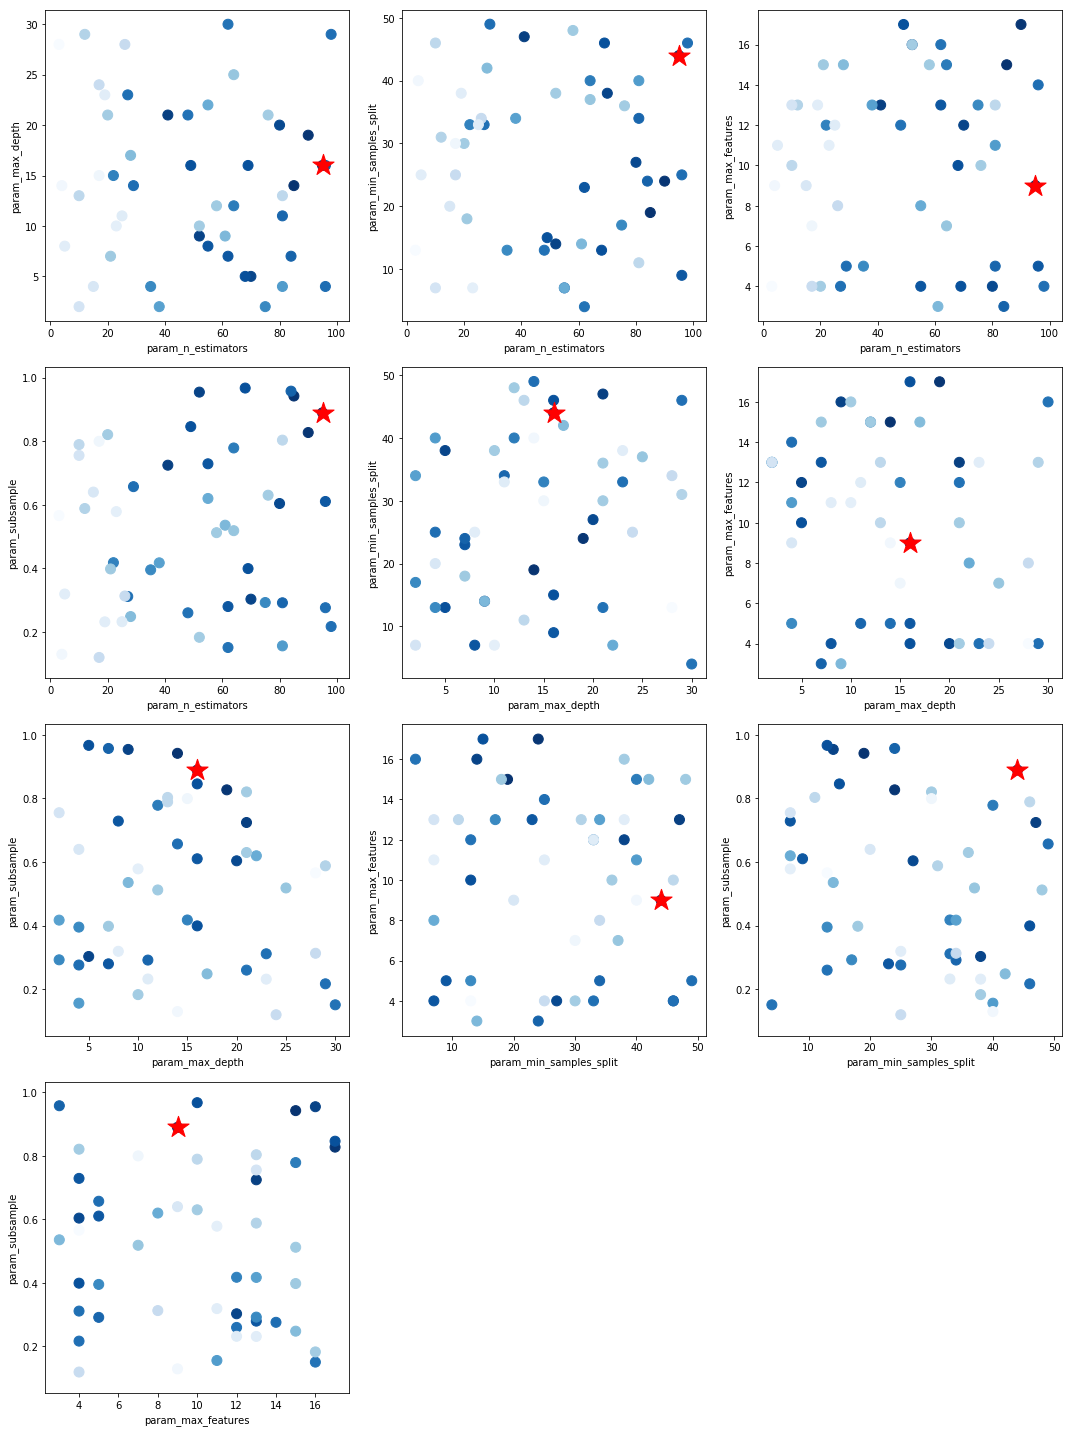

In [8]:
params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_max_features', 'param_subsample']
gs = gridspec.GridSpec(4,3)
fig = plt.figure(figsize=(15, 20), tight_layout=True)
plt_best = cv_results.head(1)
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

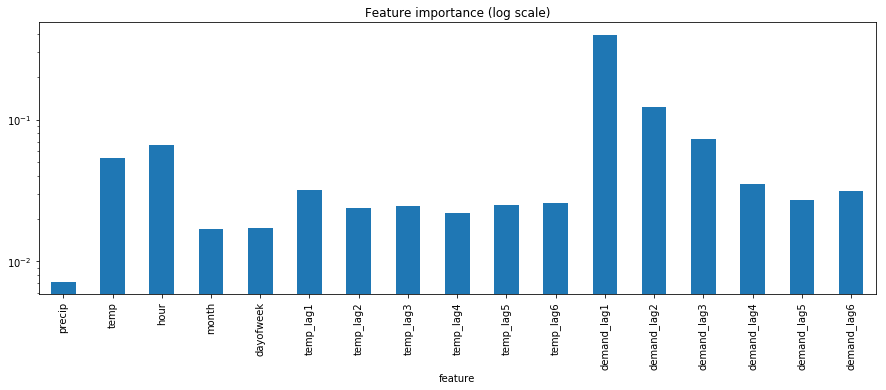

In [9]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), logy=True, title='Feature importance (log scale)', legend=False)
plt.show()